In [1]:
import copy

import networkx
import shapely.geometry
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# We're in engineering cordinates
coords = [
    [0, 0],
    [100, 0],
    [200, 0],
    [100, 100]
]

# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [1, 3]
]

In [3]:
points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

nodes = [
    dict(
        geometry=point,
        x=point.x,
        y=point.y,
        node_i=node_i
    )
    for node_i, point
    in enumerate(points)
]

In [4]:
edges = []
for e in edge_indices:
    edge_geometry = shapely.geometry.LineString([points[e[0]], points[e[1]]])
    edge_properties = dict(
        depth=12.5, 
        width=300, 
        geometry=edge_geometry, 
        length=edge_geometry.length,
        e=tuple(e)
    )
    edges.append(edge_properties)
pd.DataFrame(edges)

,depth,width,geometry,length,e
0,12.5,300,"LINESTRING (0 0, 100 0)",100.0,"(0, 1)"
1,12.5,300,"LINESTRING (100 0, 200 0)",100.0,"(1, 2)"
2,12.5,300,"LINESTRING (100 0, 100 100)",100.0,"(1, 3)"


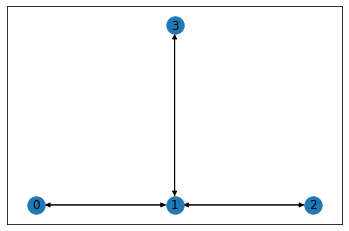

In [5]:
graph = nx.DiGraph()

for node in nodes:
    graph.add_node(node['node_i'], **node)
    
# Add up and downstream
for edge in edges:
    graph.add_edge(edge['e'][0], edge['e'][1], **edge)
    graph.add_edge(edge['e'][1], edge['e'][0], **edge)

pos = {
    node['node_i']: (node['x'], node['y']) 
    for node 
    in nodes
}

nx.draw_networkx(graph, pos=pos)


In [6]:
row = {
    "rws_type": "M8",
    "fuel": 3000,
    "H2": 999000,
    "Battery": 3300,
    "E-LNG": 432000,
    "E-Methanol": 165900
}
rows = [row]
ships = pd.DataFrame(rows)
ships

,rws_type,fuel,H2,Battery,E-LNG,E-Methanol
0,M8,3000,999000,3300,432000,165900


In [7]:
def split_edge(edge, distance=20):
    """compute points (list of shapely points) and edges ({e: linestring}) that we can use to replace an edge by points in between"""
    distances = np.arange(0, edge['geometry'].length + distance, distance)
    
    # The determine the points based on the distances
    points = [
        edge['geometry'].interpolate(distance) 
        for distance 
        in distances
    ]
    
    edges = {}
    # loop over the start, end point pairs
    edge_pairs = list(
        zip(
            points[:-1], 
            points[1:]
        )
    )
    for edge_i, (point_a, point_b) in enumerate(edge_pairs):    
        edge_geometry = shapely.geometry.LineString([point_a, point_b])
        node_a = edge_i
        node_b = edge_i + 1
        edges[(node_a, node_b)] = edge_geometry
    return points, edges

def split_and_replace_edge(graph, edge, distance=20):
    """remove edge from the network and replace it by points in between"""
    # Remember the edge to remove
    e_replace = edge['e']
    # determine the points that we want to intersect
    intersection_points, intersection_edges = split_edge(edge, distance=distance)
    # Try and remove the previous edges, if it fails, that's ok
    try:
        graph.remove_edge(e_replace[0], e_replace[1])
    except nx.NetworkXError:
        pass
    # also remove the oposite edge direction
    try:
        graph.remove_edge(e_replace[1], e_replace[0])
    except nx.NetworkXError:
        pass

    # start at the start of our replaced edge
    nodes = [graph.nodes[e_replace[0]]]
    # all the points in between
    for node_i, point in enumerate(intersection_points[1:-1]):
        node_id = f'{e_replace[0]}-{node_i}-{e_replace[1]}'
        node_properties = dict(
            geometry=point,
            x=point.x,
            y=point.y,
            node_i=node_id
        )
        nodes.append(node_properties)
    # end at the end of our edge
    nodes.append(graph.nodes[e_replace[1]])

    # add all the node properties, skip first and last, because they already exist
    for node in nodes[1:-1]:
        node_i = node['node_i']
        pos[node_i] = [node['x'], node['y']]
        # add the nodes in between
        graph.add_node(node_i, **node)
        

    # now loop over all the node pairs in between our edge
    edges = []
    for node_a, node_b in zip(nodes[:-1], nodes[1:]):
        # this is our new edge
        e = (node_a['node_i'], node_b['node_i'])
        # create a new geometry
        edge_geometry = shapely.geometry.LineString([
            node_a['geometry'], 
            node_b['geometry']
        ])
        # we might want to copy the old properties
        # for now this is hard coded
        # at least replace e, edge_geometry
        edge_properties = dict(
            depth=12.5, 
            width=300, 
            geometry=edge_geometry, 
            length=edge_geometry.length,
            e=tuple(e)
        )
        edges.append(edge_properties)

    # now that we have all our edges computed
    for edge in edges:
        # insert them in two directions
        e = edge['e']
        graph.add_edge(e[0], e[1], **edge)
        graph.add_edge(e[1], e[0], **edge)


In [8]:
        
split_and_replace_edge(graph, edges[0], distance=20)
split_and_replace_edge(graph, edges[1], distance=20)

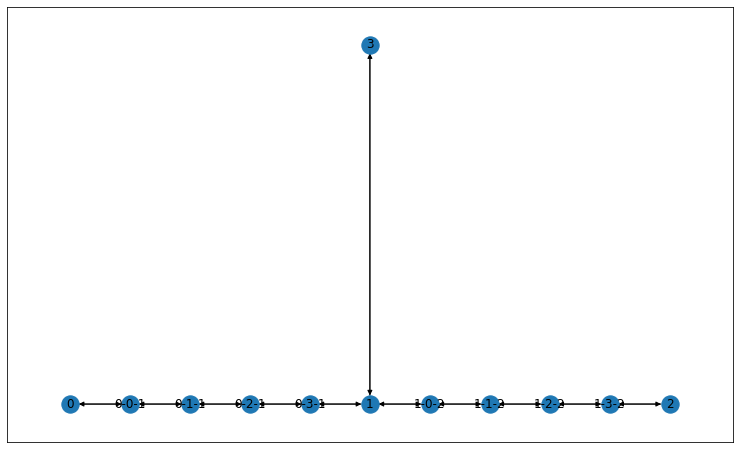

In [9]:
fig, ax = plt.subplots(figsize=(13, 8))
nx.draw_networkx(graph, pos=pos, ax=ax)